In [2]:
import torch
import sys
import os

sys.path.append('..')

In [3]:
from torch.utils.data import DataLoader

from dataset import get_dataset
from datasets.gqn import Scene
from models import get_model_genesis as get_model
from preprocess import Dummy, Quantization, Range

from torchvision.utils import make_grid
from matplotlib.pyplot import imshow, figure, scatter, colorbar, hist
import matplotlib.pyplot as plt
import matplotlib as mpl

use_gpu = torch.cuda.is_available()
device = torch.device('cuda' if use_gpu else 'cpu')
num_gpus = torch.cuda.device_count()

In [4]:
# Get dataset
dataset = 'rooms_ring_camera'
data_root = '/data/public/rw/datsets/gqn/torch'
batch_size = 32
data = get_dataset(dataset, data_root, batch_size)

kwargs = {
    'pin_memory': True if use_gpu else False,
    'shuffle': False,
    'num_workers': num_gpus * 4
}

loader = DataLoader(data['test'], batch_size * num_gpus, **kwargs)

In [16]:
data1, _ = data['train'][0]
dims = list(data1.shape)
param = dict(
    zdim=64,
    hdim=128,
    quant=True,
    layers=4,
    sigma=0.7
)
model, optimizaer = get_model('genesis', 1e-4, param, *dims)
if param['quant']:
    q = Quantization()
else:
    q = Range()

def view_image(img):
    imshow(img.cpu().numpy().transpose(1,2,0))
    
def view_images(t):
    t_grid = make_grid(t,nrow=3)
    imshow(t_grid.cpu().numpy().transpose(1,2,0),interpolation='nearest')

In [17]:
logroot = '/data/private/exp/genesis/rooms_ring_camera_vae'
log = 'modelgenesis_batch_size128_epoch300_num_gpu4_lr0.0001_zdim64_hdim128_quantFalse_layers4_sigma0.7/Dec01-1410'
filename = 'checkpoints/epoch_model_300.pth'
filepath = os.path.join(logroot, log, filename)
saved = torch.load(filepath)
model.load_state_dict(saved)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [18]:
model.eval()
model.to(device)

Genesis(
  (mask_vae): GatedRecurrentSBP(
    (core): VAE(
      (q_z_nn): Sequential(
        (0): GatedConv2d(
          (sigmoid): Sigmoid()
          (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (h_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (g_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GatedConv2d(
          (sigmoid): Sigmoid()
          (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
          (h_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (g_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): GatedConv2d(
          (sigmoid): Sigmoid()
          (conv): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (h_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [19]:
with torch.no_grad():
    x, _ = data['test'][0]
    x = x.view(1, 3, 64, 64)
    x_p = q.preprocess(x)
    x_p = x_p.to(device)
    recon_p, recon_k_p, x_mu_k, ms_k, kl_m, kl_c = model(x_p)
    recon = q.postprocess(recon_p)
    recon_k = q.postprocess(recon_k_p)
    

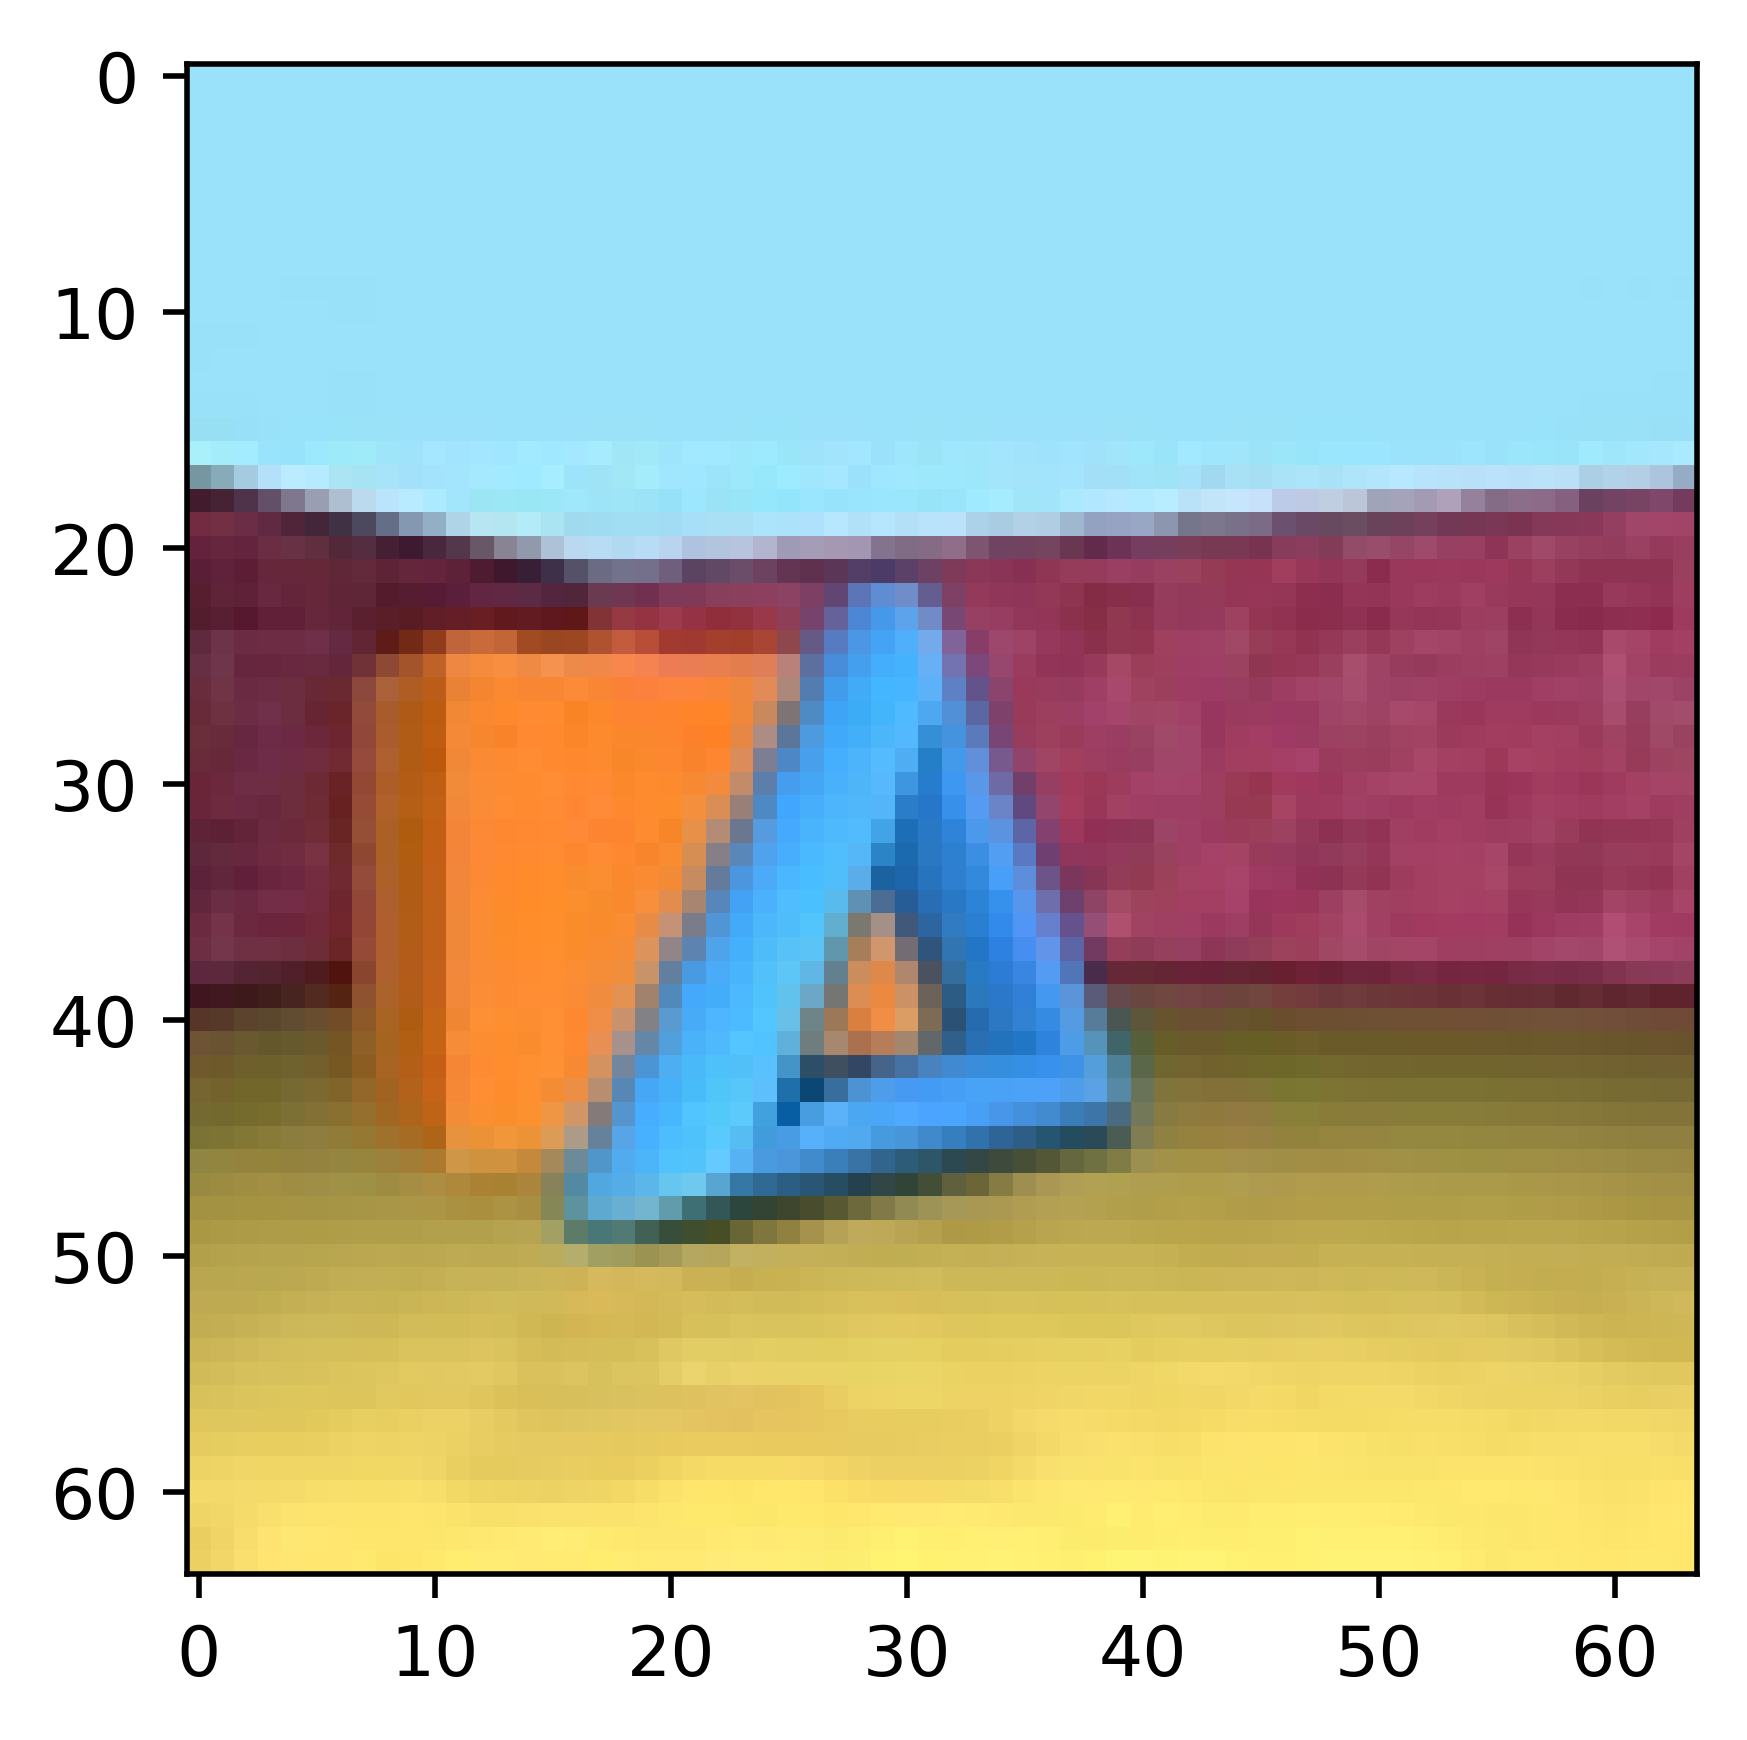

In [20]:
view_image(x.view(3, 64, 64))

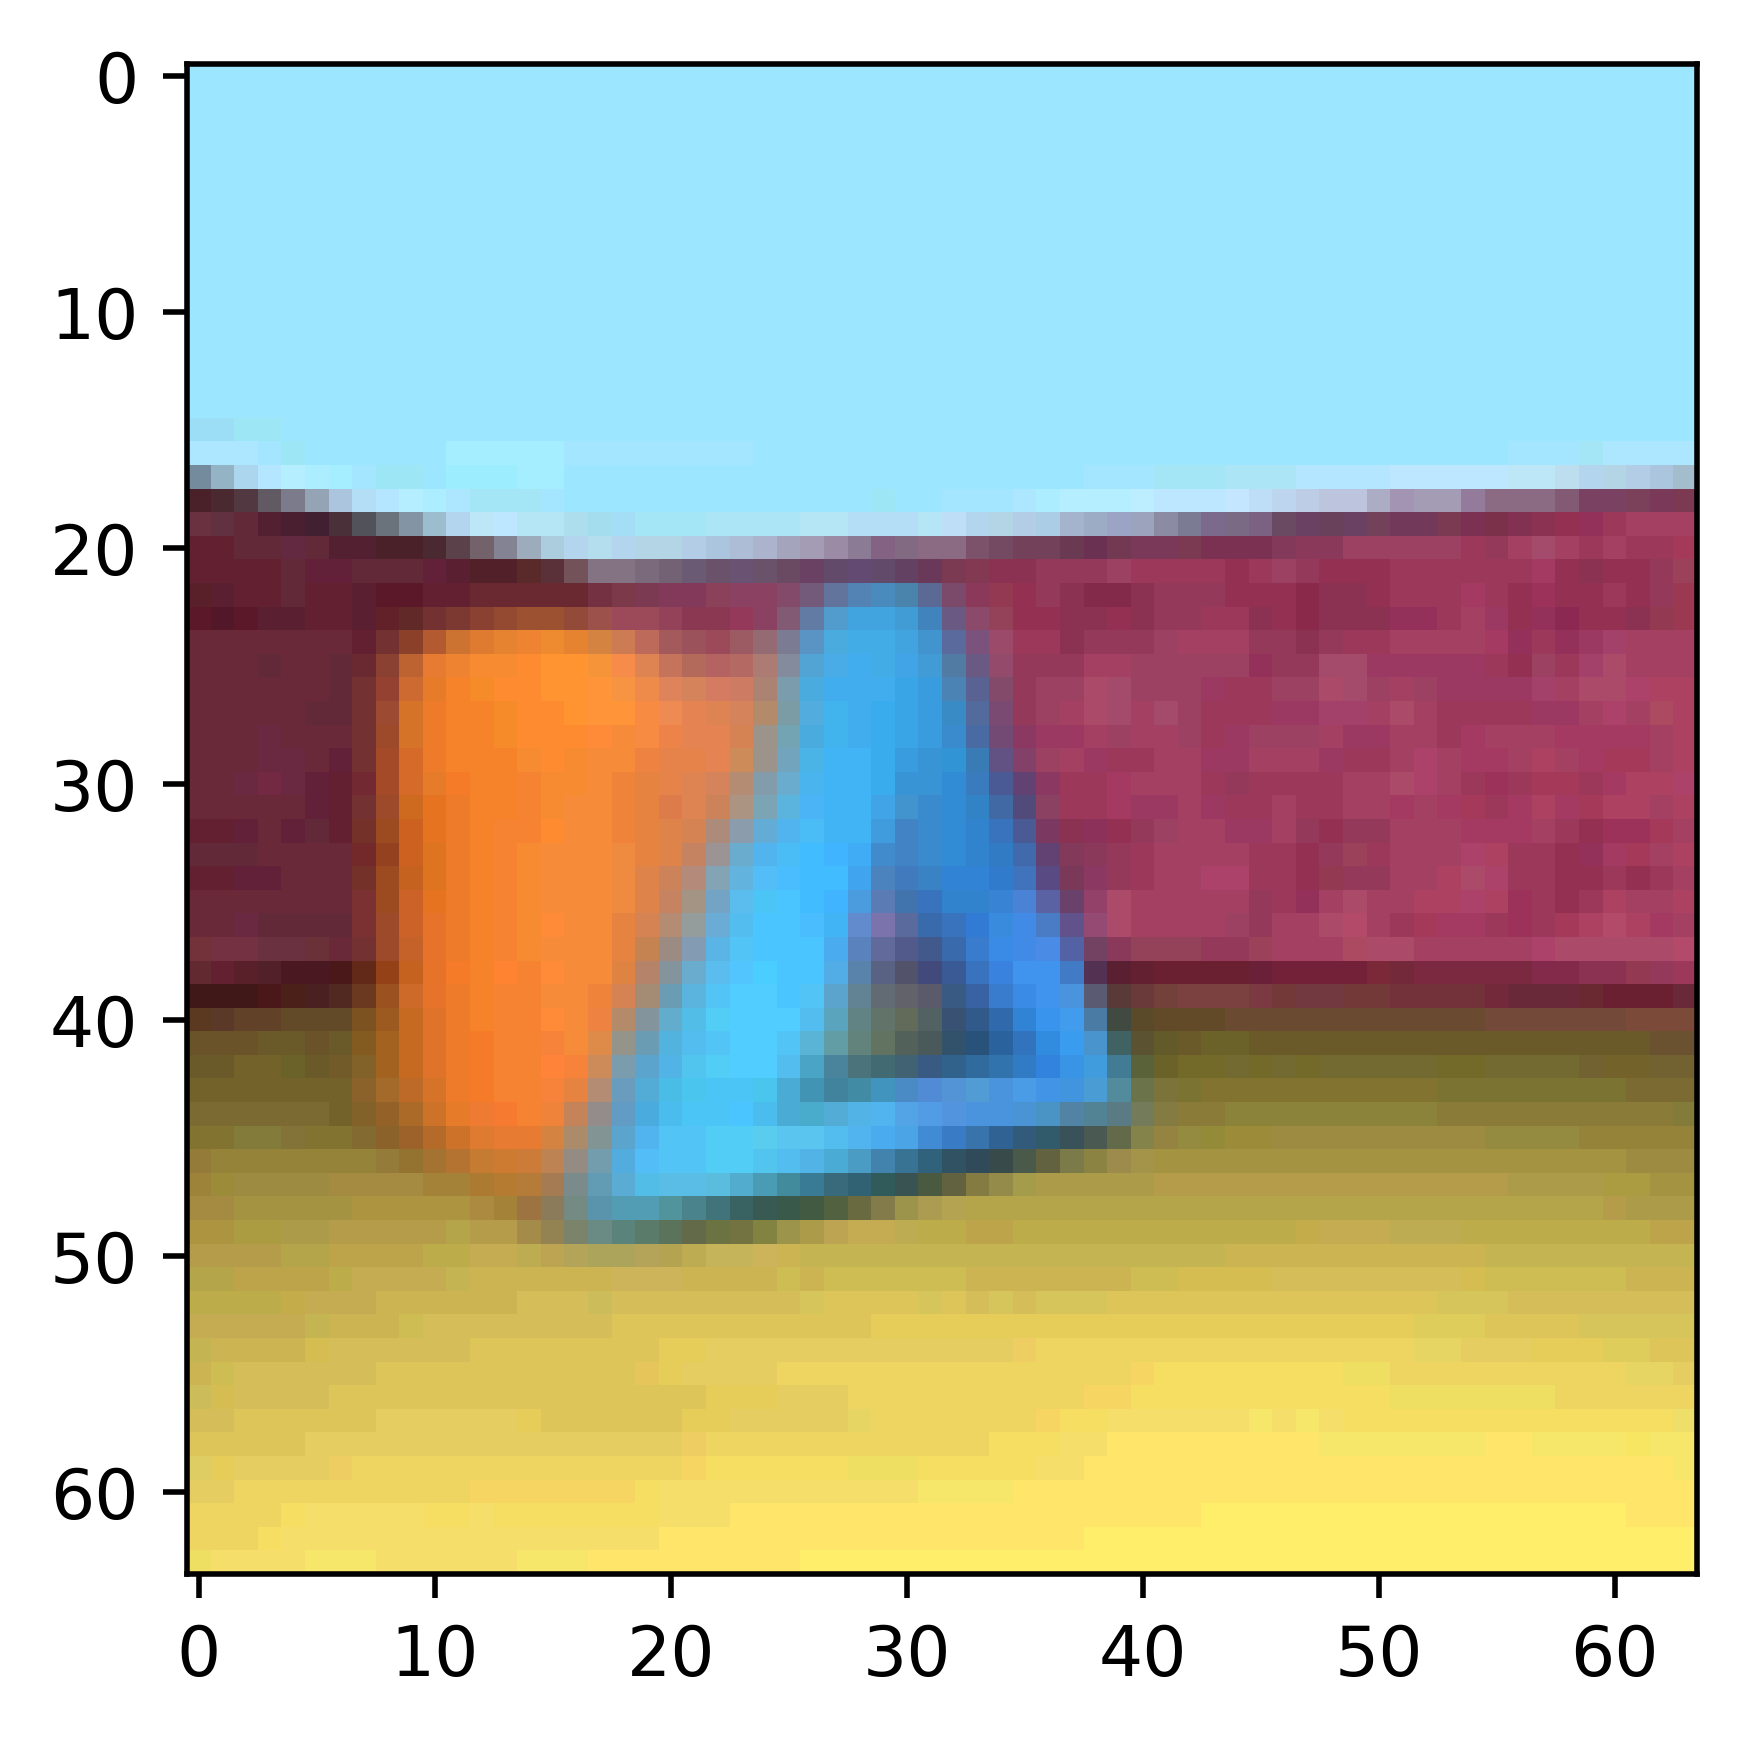

In [21]:
view_image(recon.view(3, 64, 64))

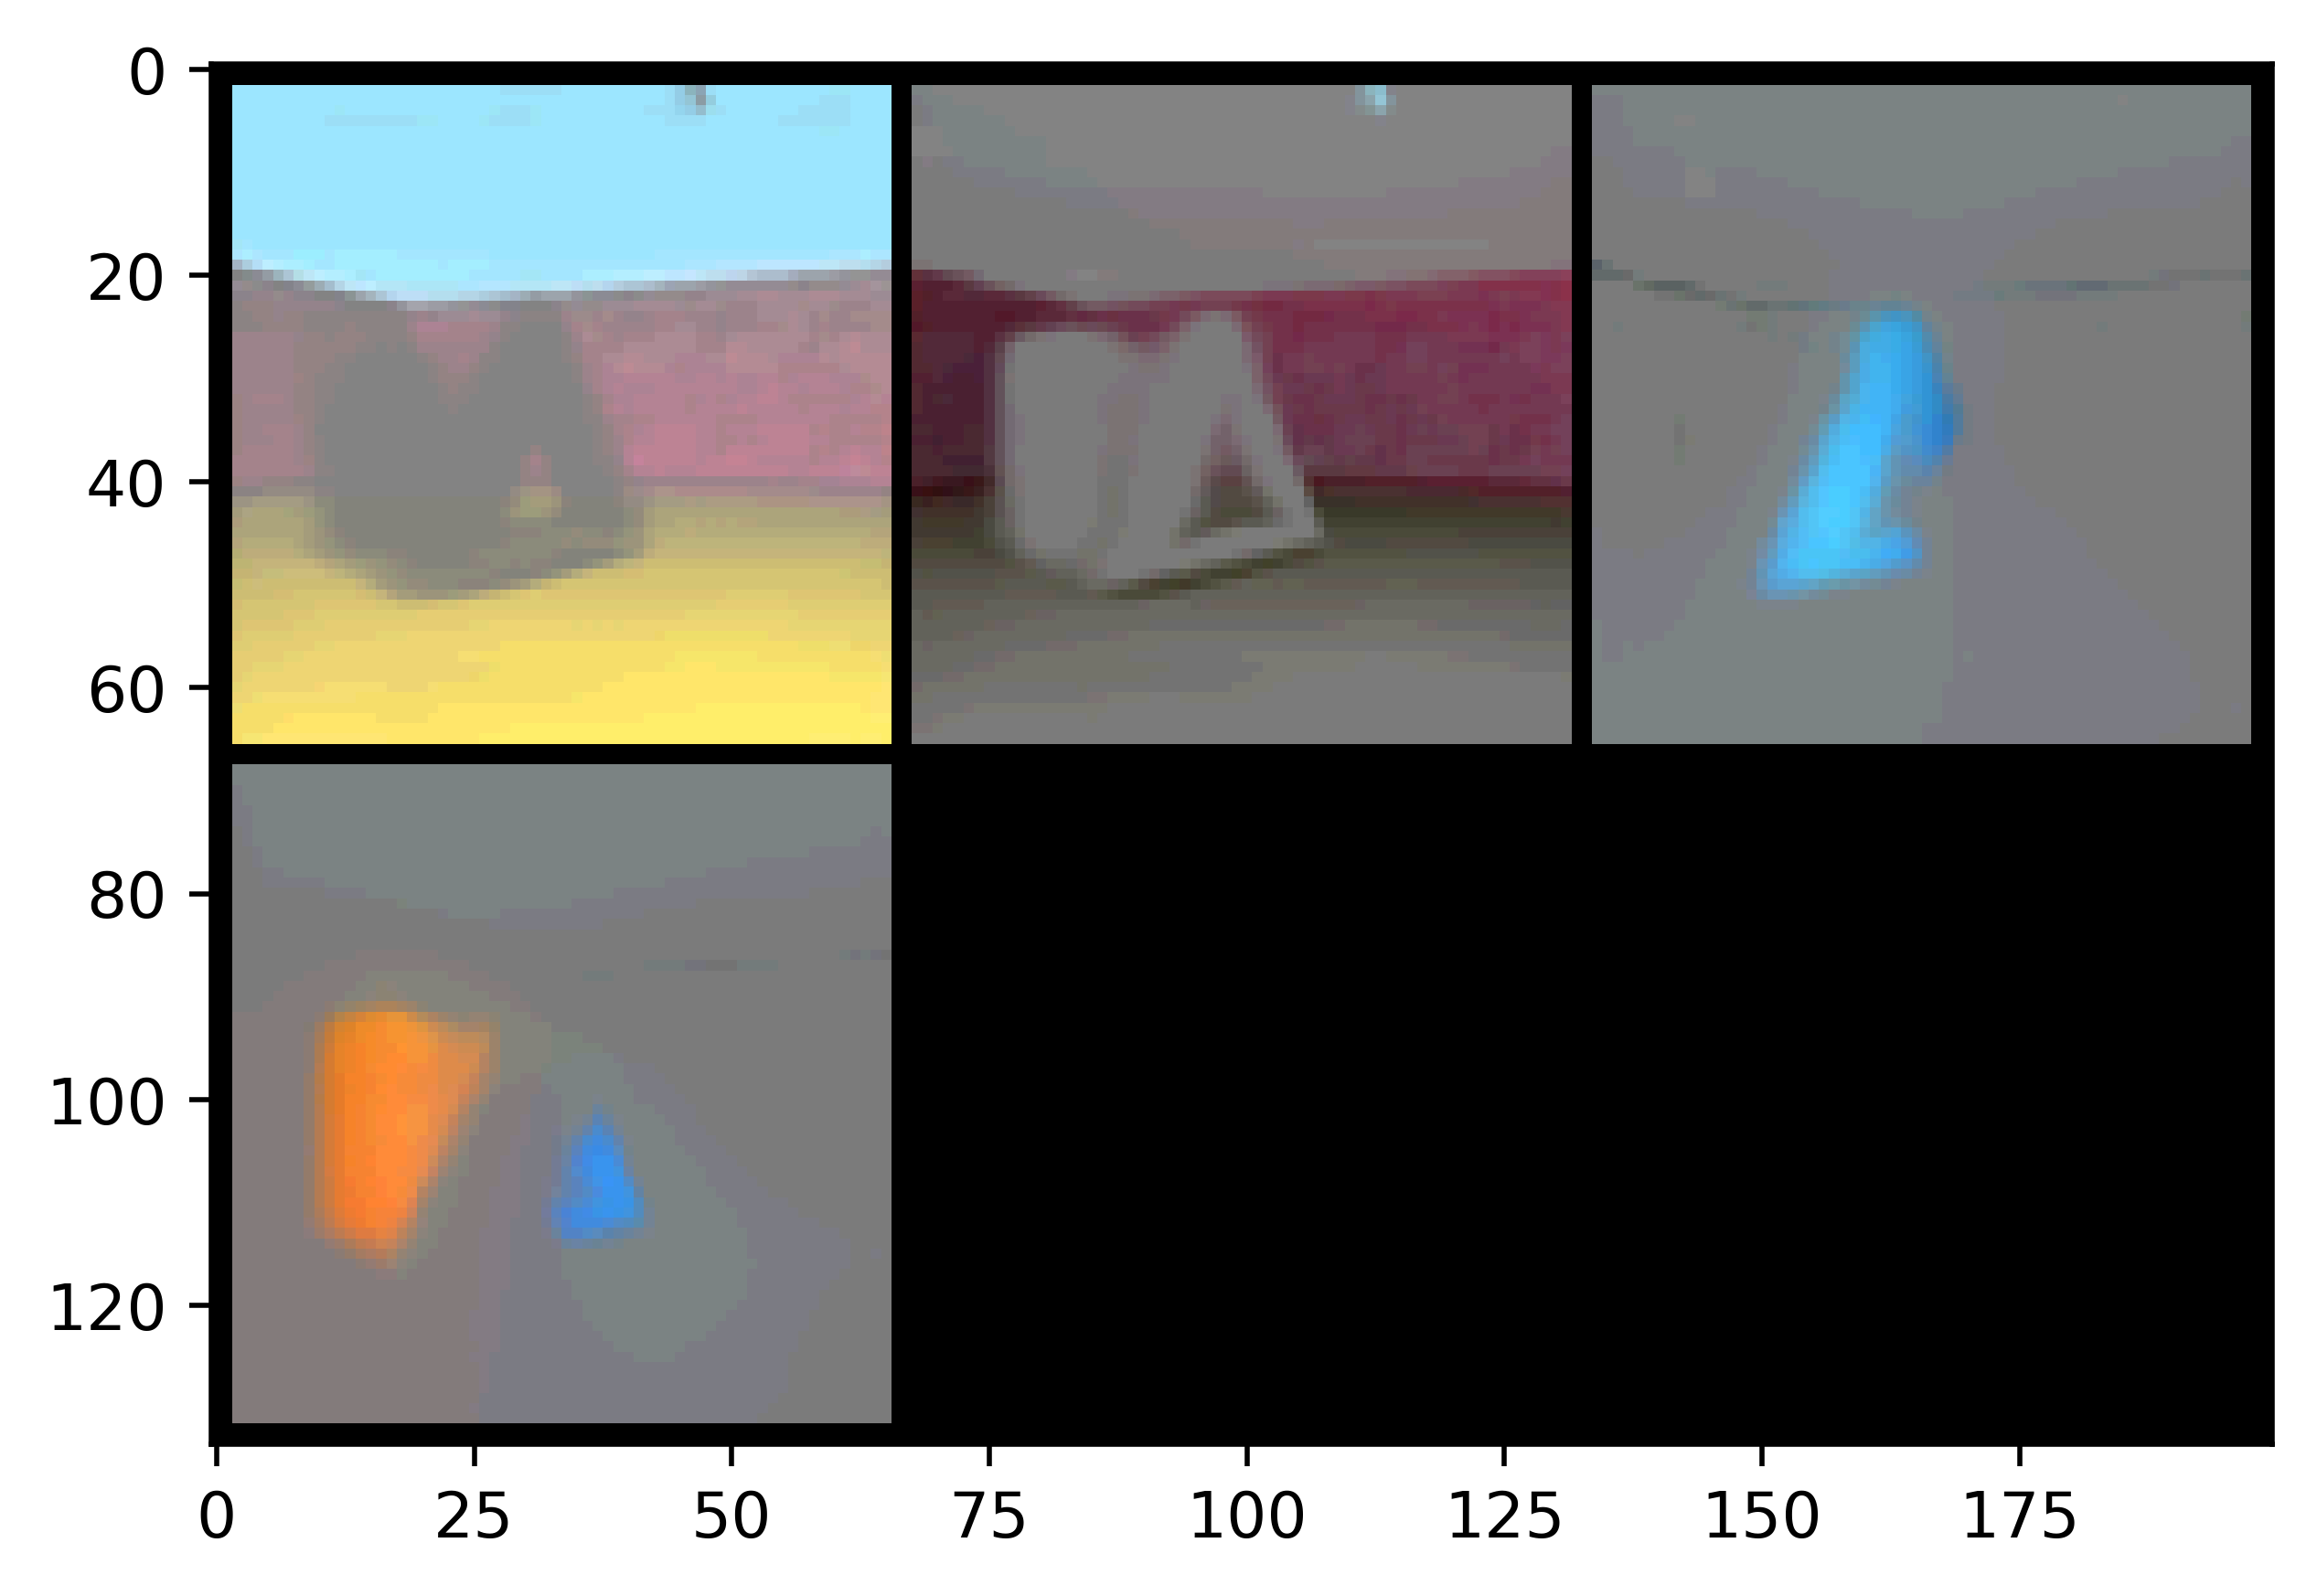

In [22]:
mpl.rcParams['figure.dpi'] = 500

view_images(recon_k.squeeze(0).permute(3, 0, 1, 2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


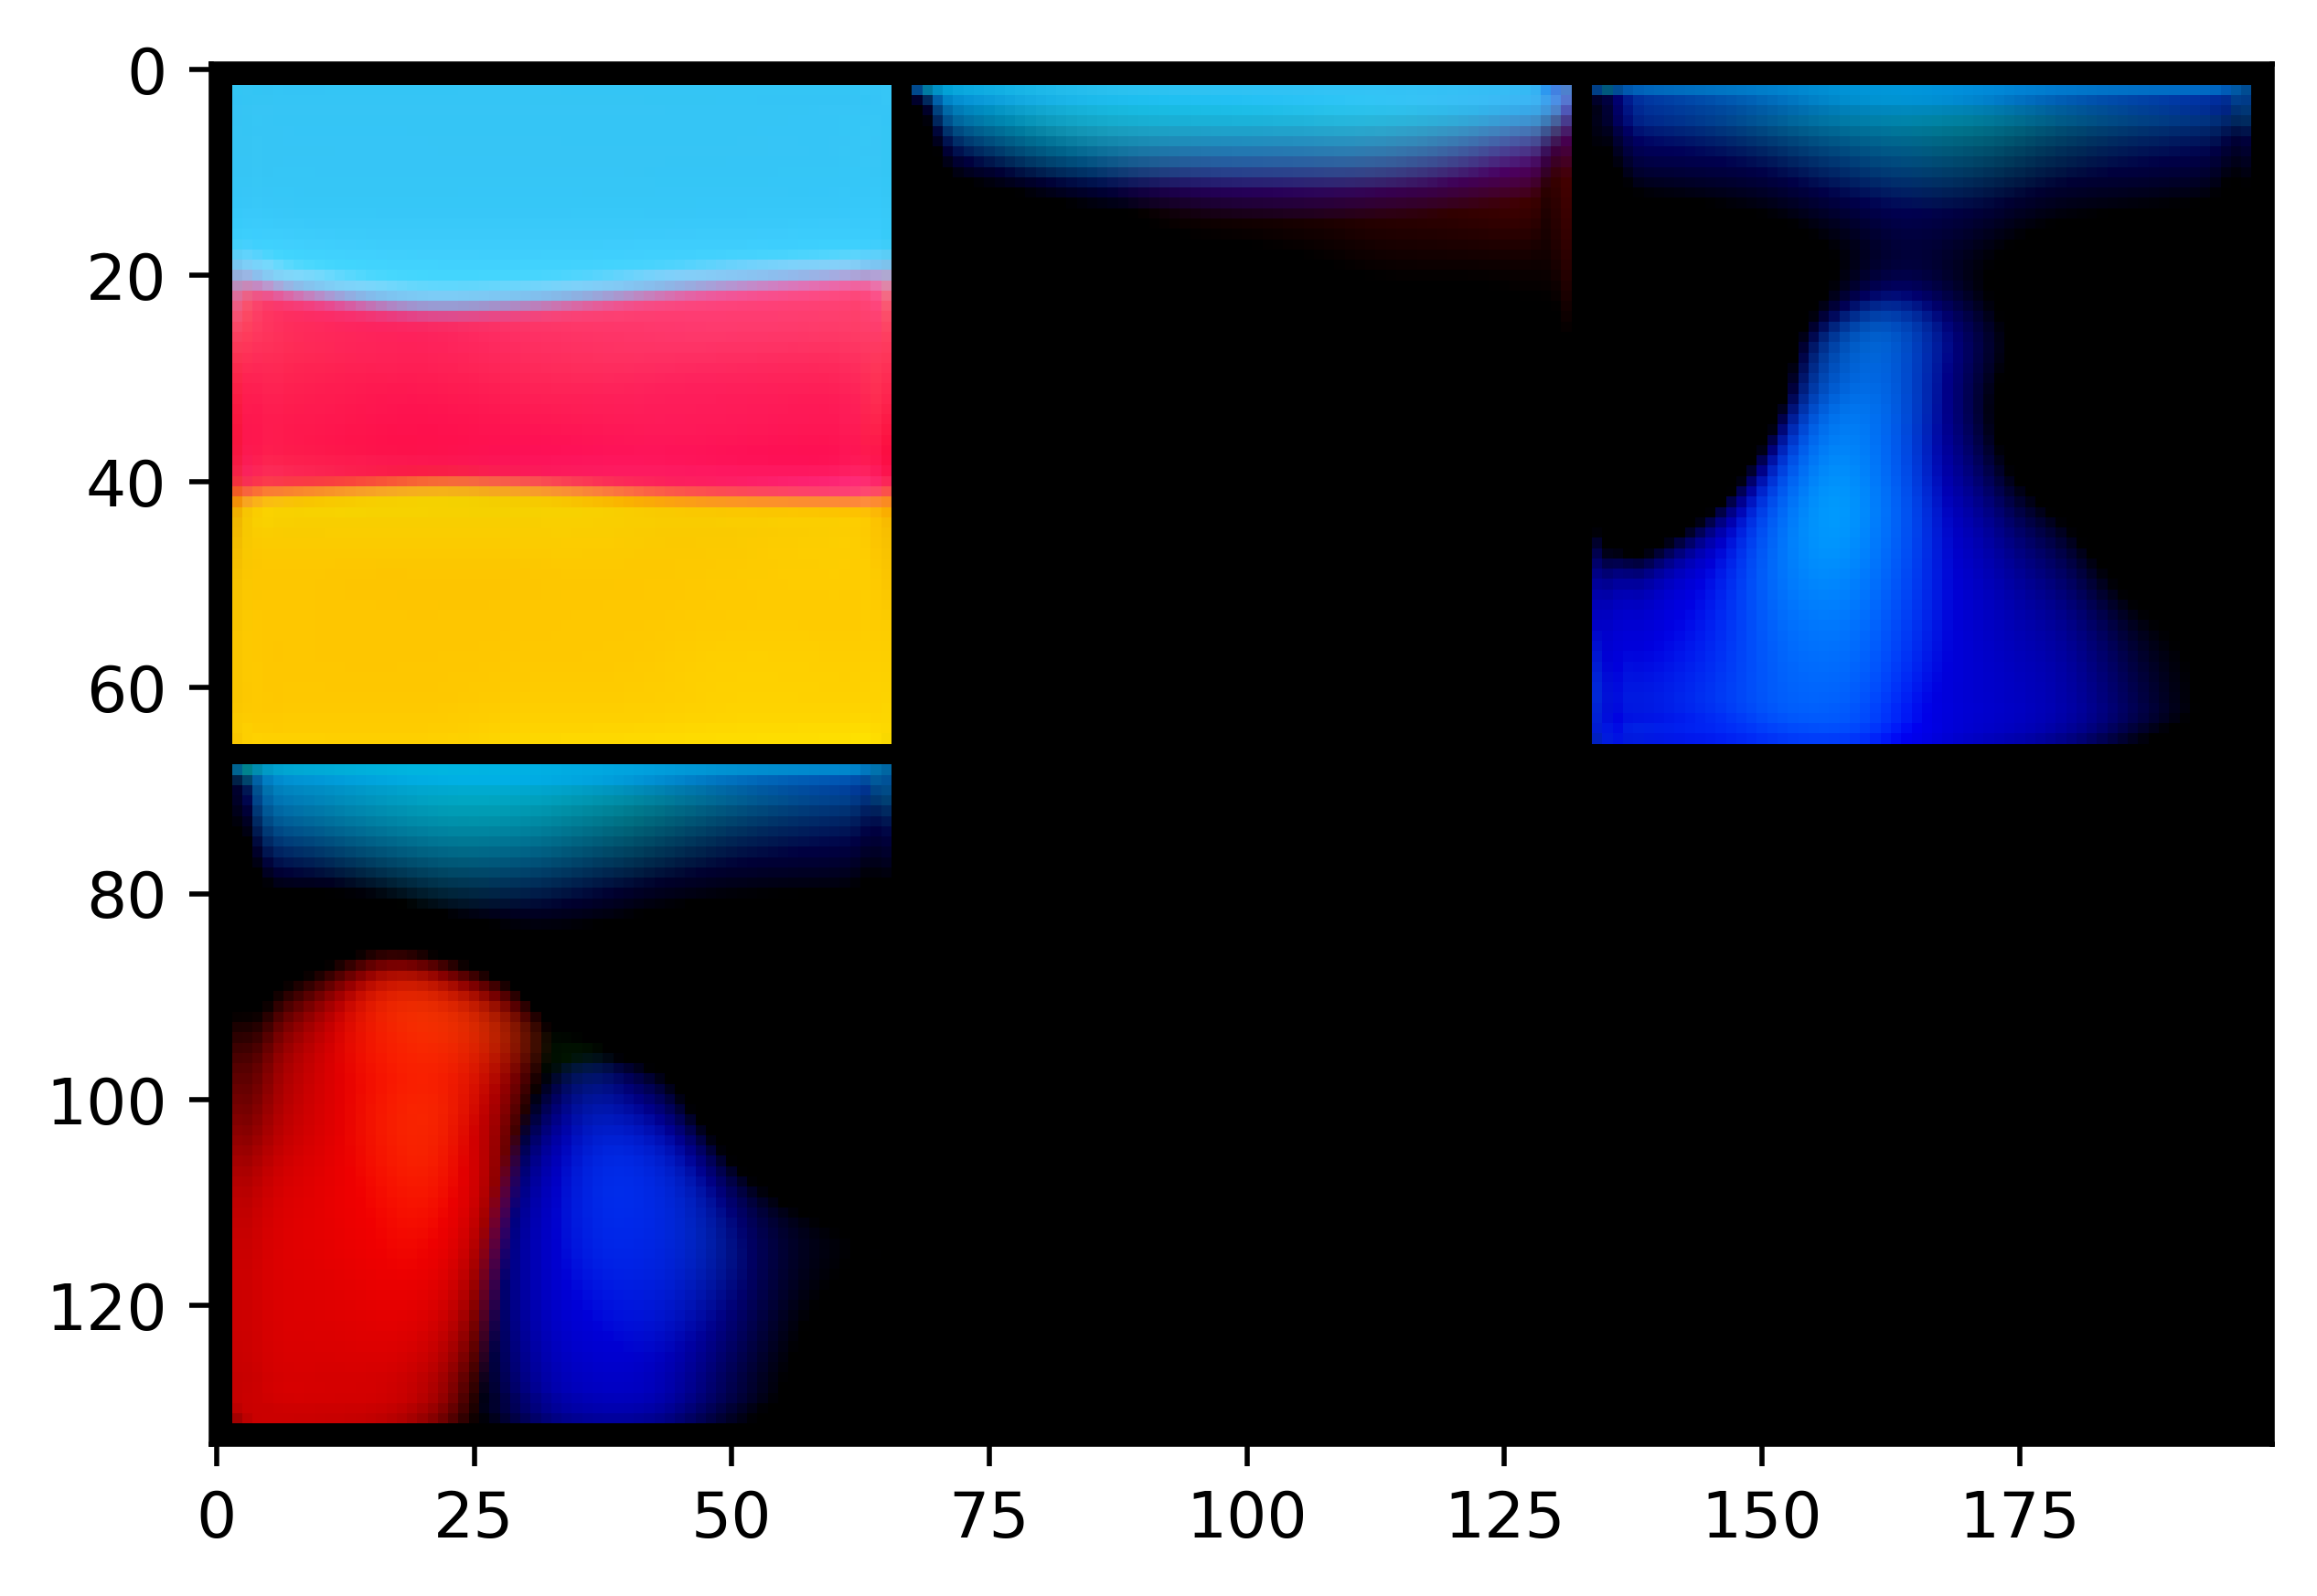

In [23]:
mpl.rcParams['figure.dpi'] = 500
view_images(x_mu_k.squeeze(0).permute(3, 0, 1, 2))

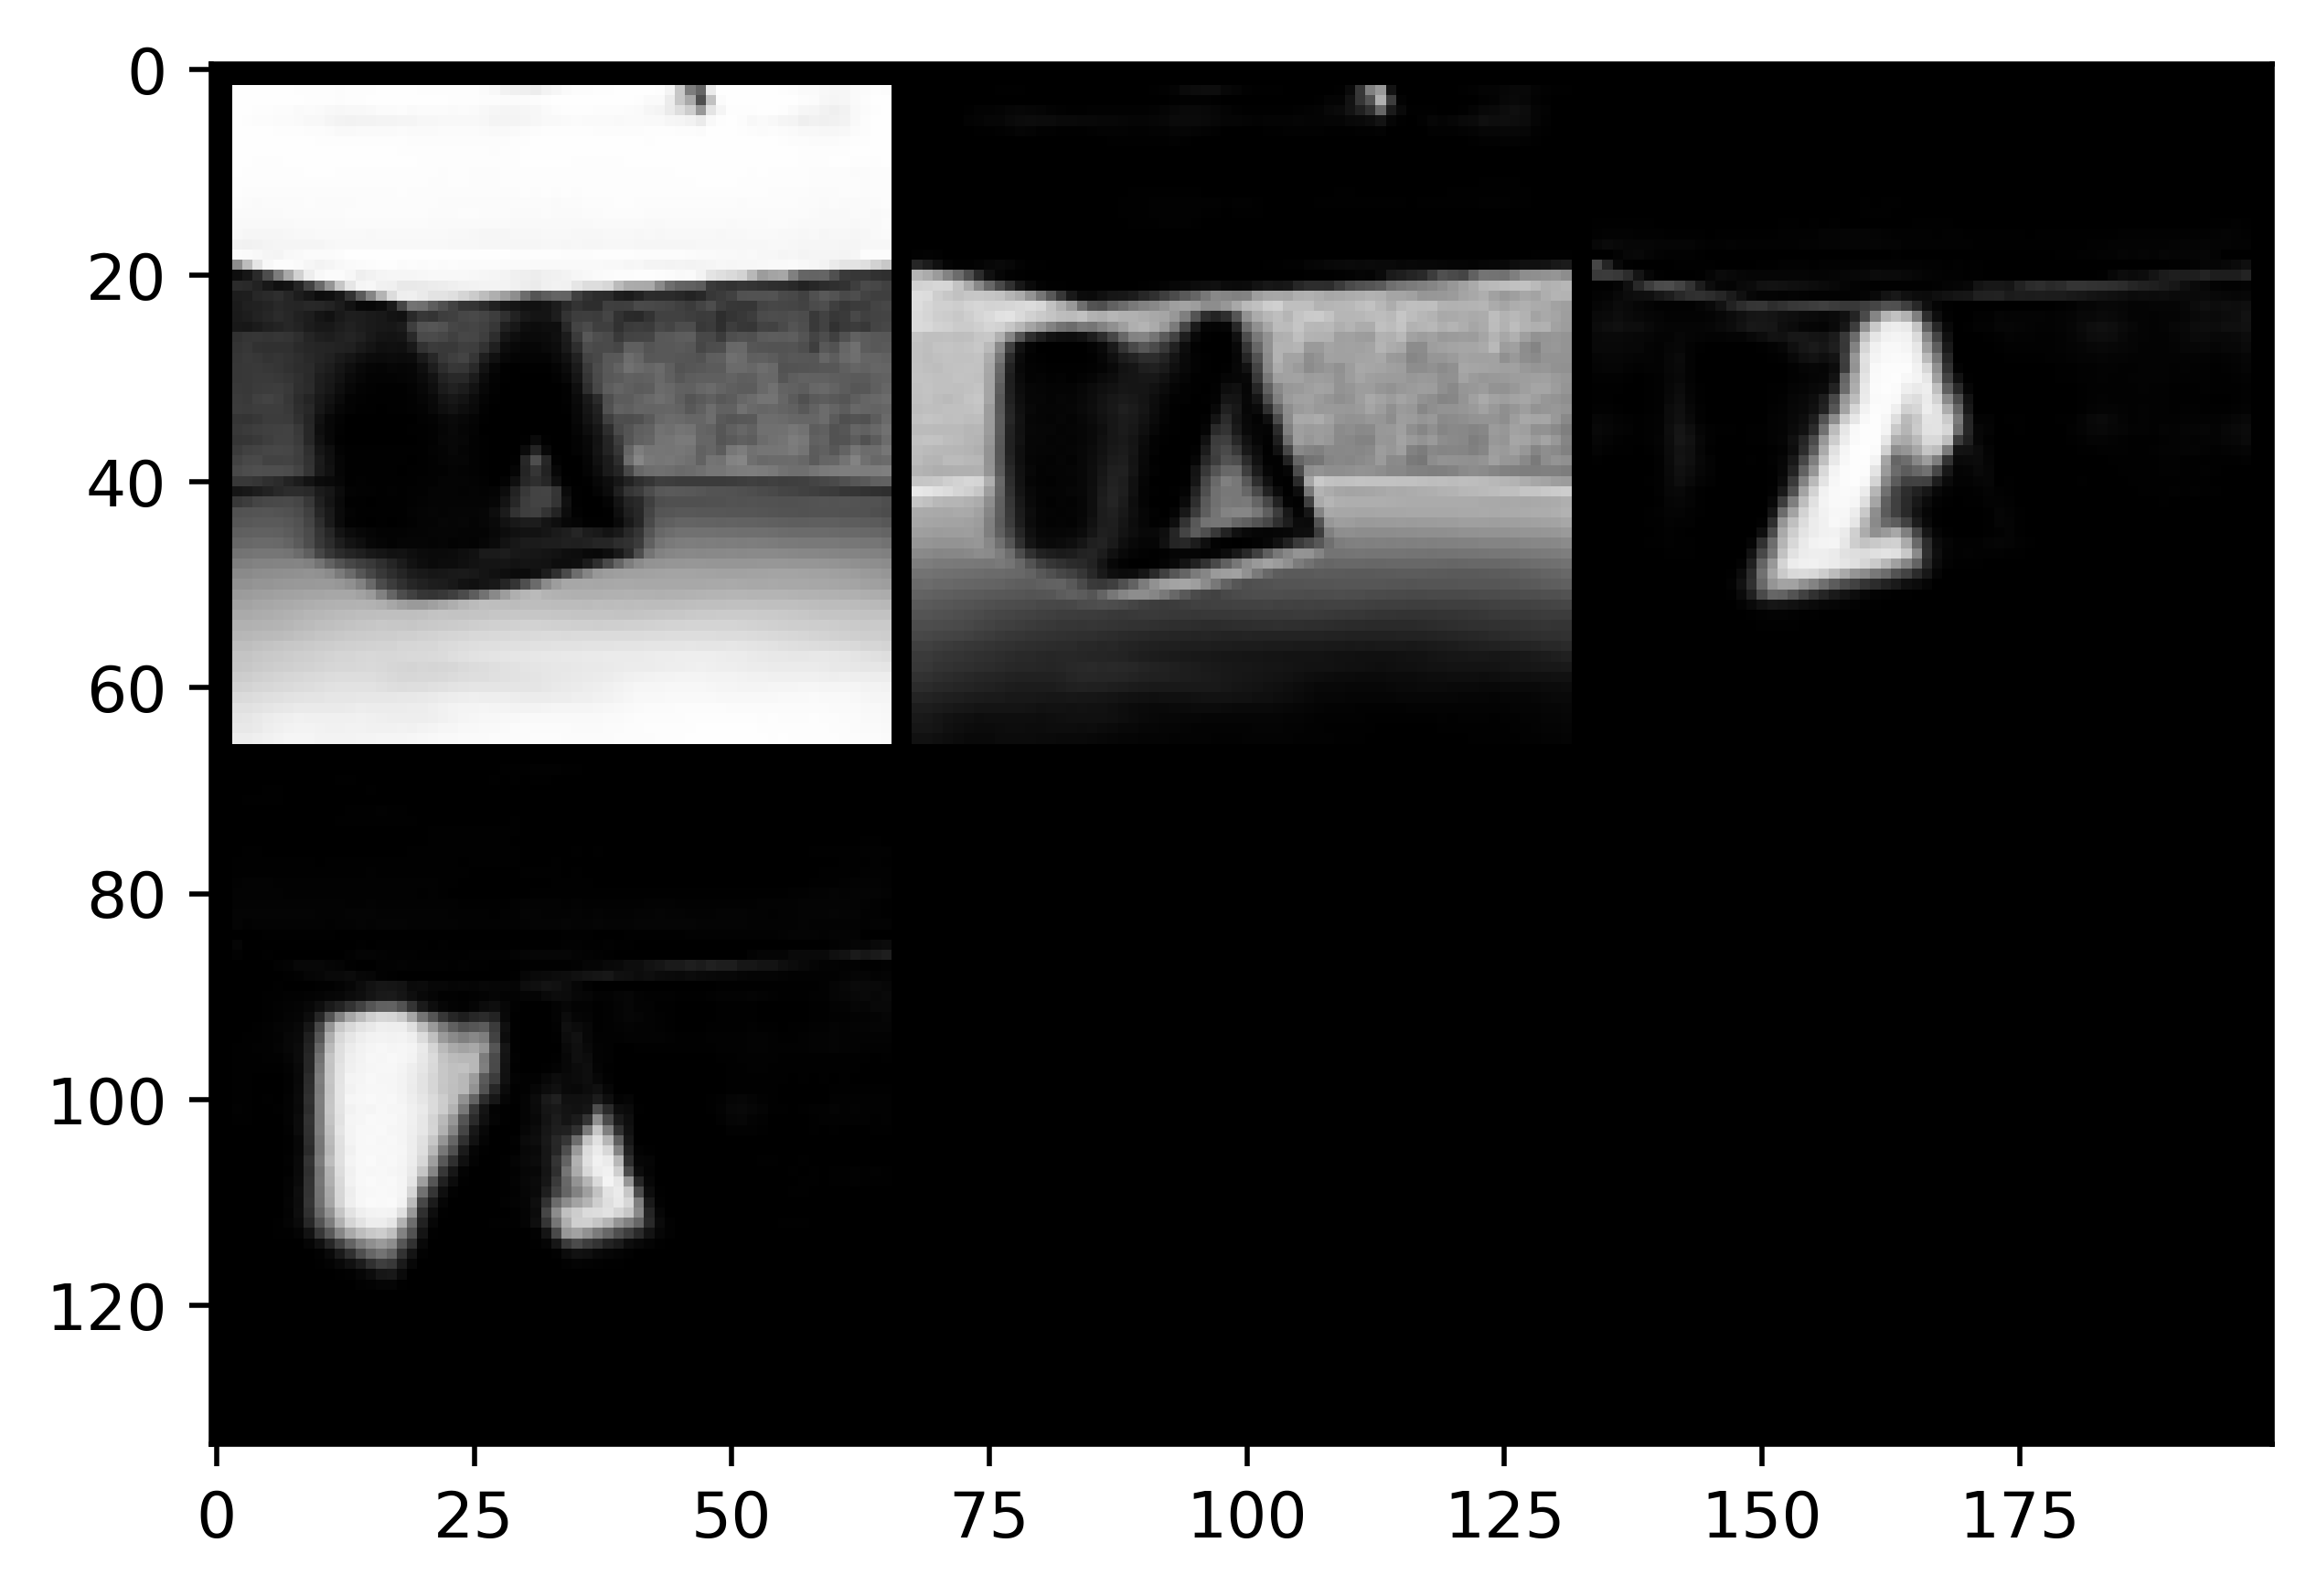

In [24]:
mpl.rcParams['figure.dpi'] = 500
view_images(ms_k.squeeze(0).permute(3, 0, 1, 2))

(array([7086., 1044.,  481.,  290.,  241.,  182.,  161.,  142.,  132.,
         122.,  110.,  111.,   59.,   96.,   79.,   82.,   69.,   72.,
          75.,   67.,   68.,   69.,   79.,   78.,   68.,   71.,   59.,
          52.,   52.,   62.,   65.,   43.,   72.,   83.,   62.,   58.,
          70.,   62.,   60.,   57.,   71.,   49.,   47.,   37.,   40.,
          43.,   45.,   41.,   31.,   43.,   46.,   36.,   47.,   43.,
          41.,   51.,   42.,   58.,   54.,   69.,   59.,   64.,   57.,
          61.,   76.,   53.,   76.,   49.,   38.,   57.,   55.,   39.,
          37.,   51.,   70.,   65.,   66.,   49.,   39.,   39.,   35.,
          41.,   35.,   46.,   51.,   46.,   52.,   35.,   50.,   58.,
          58.,   49.,   62.,   81.,   76.,  106.,  188.,  270.,  380.,
         640.]),
 array([1.3088870e-10, 9.9989912e-03, 1.9997982e-02, 2.9996973e-02,
        3.9995965e-02, 4.9994953e-02, 5.9993945e-02, 6.9992937e-02,
        7.9991929e-02, 8.9990921e-02, 9.9989906e-02, 1.0998890e-01

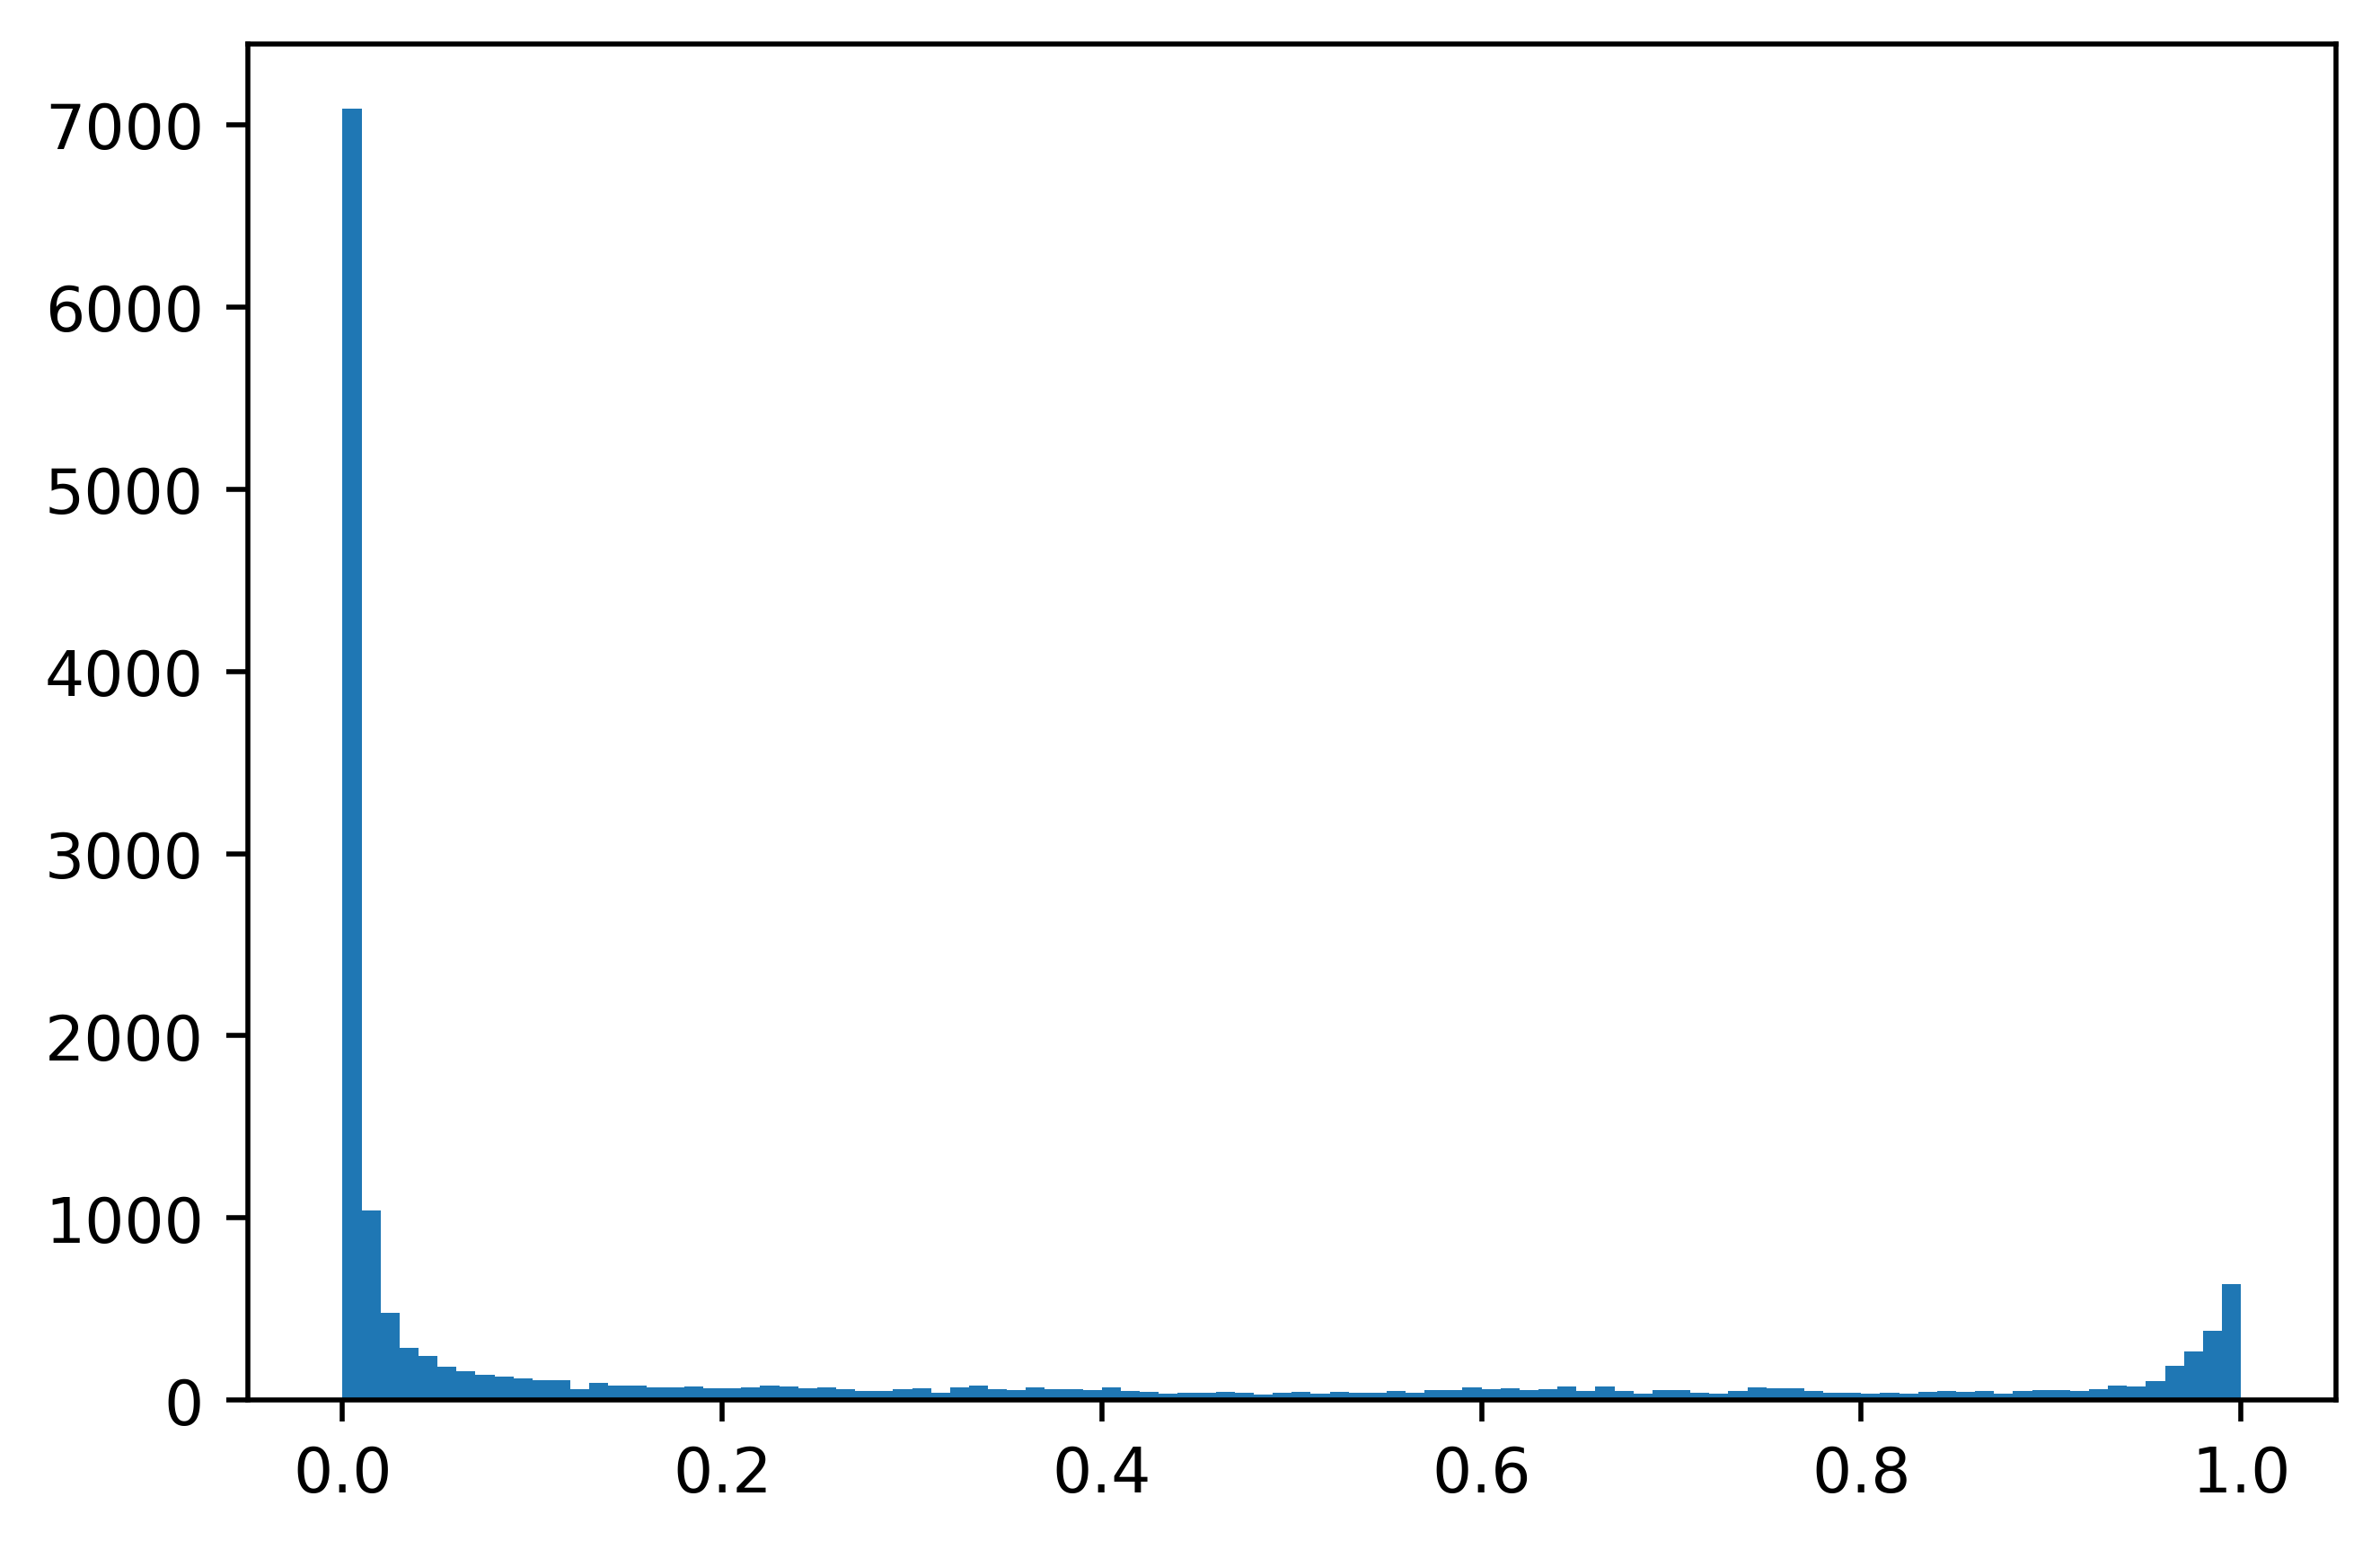

In [26]:
ms_1 = ms_k[0, 0, :, :, ]
ms_1.shape
hist(ms_1.view(-1).cpu().numpy(),100)